DL network architecture for LeNet-5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np

class LeNet5(nn.Module):
    def __init__(self, num_of_classes):
        # Initialize the parent class (nn.Module)
        super(LeNet5, self).__init__()
        ''' we are using three channels as input (insted of 1) for some experiments that will be done later '''
        # Layer 1: Convolutional + Pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)  # 28x28 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14

        # Layer 2: Convolutional + Pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)  # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 10x10 -> 5x5

        # Layer 3: Fully Connected
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)

        # Layer 4: Fully Connected
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        # Layer 5: Output Layer
        self.fc3 = nn.Linear(in_features=84, out_features=num_of_classes)

    def forward(self, x):
        # Layer 1: Conv -> Pool -> Activation
        x = F.relu(self.pool1(self.conv1(x)))

        # Layer 2: Conv -> Pool -> Activation
        x = F.relu(self.pool2(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 16 * 5 * 5)

        # Layer 3: Fully Connected + Activation
        x = F.relu(self.fc1(x))

        # Layer 4: Fully Connected + Activation
        x = F.relu(self.fc2(x))

        # Layer 5: Fully Connected (Output)
        x = self.fc3(x)

        return x

# Creating a model object/instance
model = LeNet5(num_of_classes=10)
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
''' define unique color for each digit [0,9]'''
colors = [
    (1, 0, 0),  # Red for 0
    (0, 1, 0),  # Green for 1
    (0, 0, 1),  # Blue for 2
    (1, 1, 0),  # Yellow for 3
    (1, 0, 1),  # Magenta for 4
    (0, 1, 1),  # Cyan for 5
    (0.5, 0, 0),  # Dark Red for 6
    (0, 0.5, 0),  # Dark Green for 7
    (0, 0, 0.5),  # Dark Blue for 8
    (0.5, 0.5, 0)  # Olive for 9
          ]

# Function to add color bias based on the label
def ColorBiasTransform(img, label):
    # comvert to np array to perform other operations
    img = np.array(img)
    # Convert grayscale to RGB
    ''' convert grayscale image from MNIST to RGB by using repeat '''
    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    # Convert the label to an integer
    label = int(label)
    color = colors[label]
    for i in range(3):  # Apply the color to each channel
        img[:, :, i] = img[:, :, i] * color[i]

    return img

# Custom transform for colored MNIST
class CustomColorMNIST(torchvision.datasets.MNIST):
    def __getitem__(self, index):
        # get the image and label using Base class's method
        img, label = super().__getitem__(index)
        # Apply color Bias
        img = ColorBiasTransform(img, label)
        img = transforms.ToTensor()(img)  # Convert back to tensor
        return img, label

Load the data from pytorch datasets and then split into training, validation, and testing.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating channels
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5))
])
'''  Standard code from https://pytorch.org/vision/stable/datasets.html'''


# Load data with color bias for training and grayscale for testing
dataset = CustomColorMNIST(root='./data', train=True, download=True, transform=None)
# Load dataset test dataset normal (un-biased)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



# Create DataLoaders with a certain batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Visualize a few images from the batch and their labels

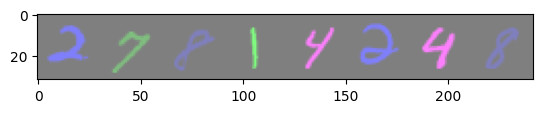

Labels: [2 7 8 1 4 2 4 8]


In [ ]:
# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    # Important when it is a Color (RGB) Image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
''' next(dataiter): Fetches the next batch from the train_loader'''
images, labels = next(dataiter)  # Use the built-in next() function


# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Show the first 8 images
print('Labels:', labels[:8].numpy())  # Print the corresponding labels

Define the device and optimizer function

In [ ]:
import torch.optim as optim

'''  Decide if the calculations are perfomed by GPU or CPU  '''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''.to(device): moves tensors and models to the specified device (either GPU or CPU).
This ensures that all computations happen on the same device, avoiding errors or inefficiencies.'''
model = model.to(device)
# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Optimizer SGD or ADAM with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training and Validation both loss and accuracy.
Please note that training for this example will be much slower due the reasons given below.

In [ ]:
from PIL import Image

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def RandomChannelSwap(img):
    if isinstance(img, Image.Image):
      img = transforms.ToTensor()(img)  # Convert to tensor if it's a PIL image

      # Generate a random permutation of the indices [0, 1, 2] for RGB channels
      perm = torch.randperm(3)

      # Apply the permutation to the channels
      img = img[perm, :, :]

    return img

# Define the augmentation that will be applied during training (ColorJitter for random jitter)
augmentation_transform = transforms.Compose([ transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
                                              transforms.Lambda(RandomChannelSwap), # Apply the channel swapping function
                                              transforms.ToPILImage(),         # Convert back to PIL image (if needed)
                                              transforms.ToTensor()

])


# number of epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        # Apply augmentation dynamically to each batch inside the training loop
        ''' Ideally these operarions should be perfomed  in CustomColorMNIST
            But for this demo they are perfomed during training and then later on in validation
         '''
        augmented_images = torch.stack([augmentation_transform(image) for image in inputs])

        # Move augmented images to the same device as the model
        augmented_images = augmented_images.to(device)
        optimizer.zero_grad()
        outputs = model(augmented_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ''' torch.max(outputs, 1): The torch.max() function returns the maximum
        value of all elements in the tensor along a specified dimension.
         (_) is used for variables that we don't need to use   '''
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)

    # append the list
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    # append the list
    train_accuracies.append(train_accuracy)

    # .eval indicates that the model is used for prediction.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Apply augmentation dynamically to each batch inside the training loop
            augmented_images = torch.stack([augmentation_transform(image) for image in inputs])
            # Move augmented images to the same device as the model
            augmented_images = augmented_images.to(device)
            outputs = model(augmented_images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 0.4244, Train Accuracy: 86.58%, Val Loss: 0.1551, Val Accuracy: 95.42%
Epoch 2/10, Train Loss: 0.1283, Train Accuracy: 96.10%, Val Loss: 0.1077, Val Accuracy: 96.64%
Epoch 3/10, Train Loss: 0.0891, Train Accuracy: 97.18%, Val Loss: 0.0847, Val Accuracy: 97.23%
Epoch 4/10, Train Loss: 0.0694, Train Accuracy: 97.88%, Val Loss: 0.0827, Val Accuracy: 97.32%
Epoch 5/10, Train Loss: 0.0573, Train Accuracy: 98.27%, Val Loss: 0.0539, Val Accuracy: 98.44%
Epoch 6/10, Train Loss: 0.0484, Train Accuracy: 98.50%, Val Loss: 0.0622, Val Accuracy: 97.88%
Epoch 7/10, Train Loss: 0.0436, Train Accuracy: 98.66%, Val Loss: 0.0428, Val Accuracy: 98.77%
Epoch 8/10, Train Loss: 0.0376, Train Accuracy: 98.84%, Val Loss: 0.0463, Val Accuracy: 98.58%
Epoch 9/10, Train Loss: 0.0354, Train Accuracy: 98.92%, Val Loss: 0.0457, Val Accuracy: 98.57%
Epoch 10/10, Train Loss: 0.0306, Train Accuracy: 99.05%, Val Loss: 0.0393, Val Accuracy: 98.89%


Plot the Training and Validation performances over epochs

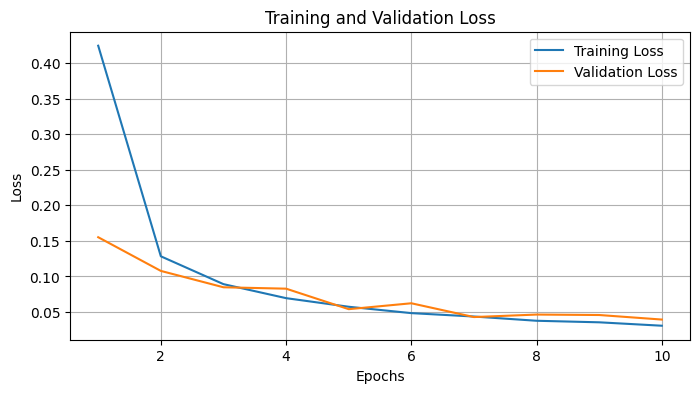

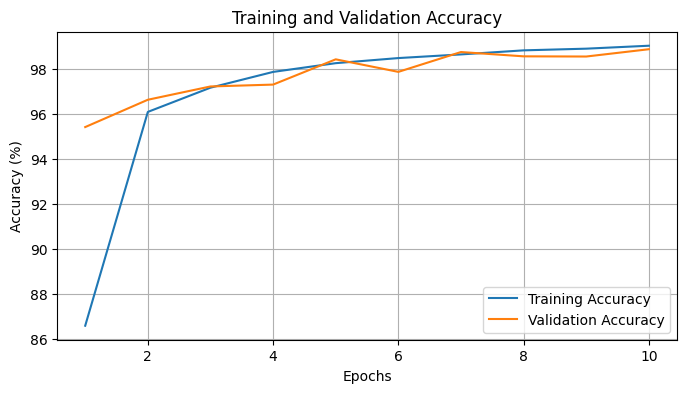

In [ ]:

# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Test the perfroance of the trained model for test data

In [ ]:
# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 5.1485, Test Accuracy: 74.89%


Visualize the results for a Test batch

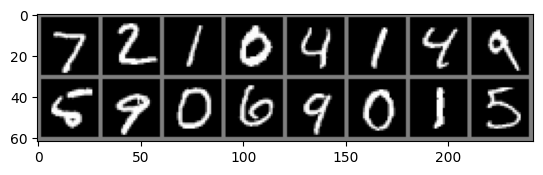

Ground Truth:     7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5
Predicted Val:    7 2 1 0 7 1 7 9 5 9 0 6 9 7 1 5


In [ ]:
# Get a batch of test data
no_of_samples = 16
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Show images
imshow(torchvision.utils.make_grid(images[:no_of_samples]))
print('Ground Truth:    ', ' '.join(f'{labels[j]}' for j in range(no_of_samples)))

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted Val:   ', ' '.join(f'{predicted[j].item()}' for j in range(no_of_samples)))
